Adapted from https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting
#Goals
- demonstrate the effects of Regular, L1, and Lasso Control with low-level control
- visualize experiment results through TensorBoard

#Imports

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile
import gzip
import pandas as pd

In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

#Dataset Preprocessing

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
mnist_data = mnist.load_data()
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = np.reshape(X_train, (60000, 28, 28, 1))
X_test = np.reshape (X_test, (10000, 28, 28, 1))

Y_train = np.eye(10)[Y_train]
Y_test = np.eye(10)[Y_test]

label: 4


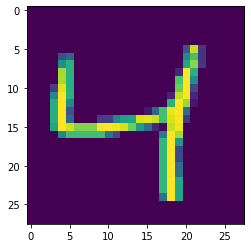

In [ ]:
def display_image (image_matrix):
  plt.imshow(np.reshape(image_matrix[:][:], (28, 28)))
def display_label (label_onehot):
  print(np.where(label_onehot==1)[0].item(0))

print ("label: ", end="")
display_label(Y_train[2])
display_image(X_train[2])

#Model Training Parameters

##Learning Rate Scheduler

In [ ]:
SIDE_LENGTH = 28
FEATURES = SIDE_LENGTH*SIDE_LENGTH

N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

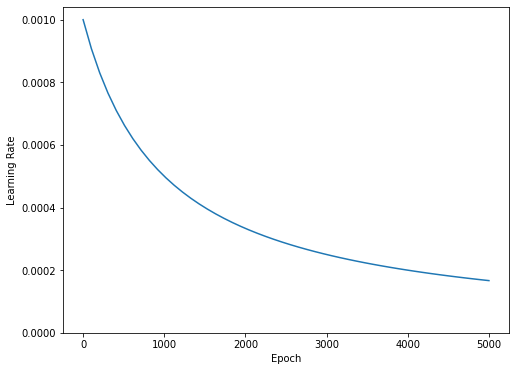

In [ ]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

##Training Callbacks

In [ ]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

##Training Method

In [ ]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(
      optimizer=optimizer,
      loss=tf.keras.losses.categorical_crossentropy,
      metrics=['accuracy']
  )

  model.summary()

  history = model.fit(
    X_train,
    Y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=(X_test, Y_test),
    callbacks=get_callbacks(name),
    verbose=1
  )
  return history

#Training Models

In [ ]:
histories = {}

In [ ]:
def getModel(regularizer, name=None):
  initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1., seed = 0)
  return tf.keras.Sequential([
    layers.Reshape((FEATURES,), input_shape=(SIDE_LENGTH, SIDE_LENGTH),),
    layers.Dense(100, activation='elu', kernel_regularizer=regularizer, kernel_initializer=initializer),
    layers.Dense(100, activation='elu', kernel_regularizer=regularizer, kernel_initializer=initializer),
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizer, kernel_initializer=initializer)
  ], name=name)

##Training Regular Model

In [ ]:
regular_model_name = "regular"
regular_model = getModel(None, regular_model_name)
histories[regular_model_name] = compile_and_fit(regular_model, regular_model_name)

##Training L1 Model

In [ ]:
l1_model_name = "L1"
l1_model = getModel(regularizers.l1(0.001), l1_model_name)
histories[l1_model_name] = compile_and_fit(l1_model, l1_model_name)

##Training Group Lasso Model
Writing a custom regularizer: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer

###Writing our custom regularizer

In [ ]:
#writing custom group regularizer
#Group Lasso Regularizer: Implementation of Eq. 2 in https://arxiv.org/pdf/1611.06321.pdf
#@tf.keras.utils.register_keras_serializable(package='Custom', name='groupLasso')
class GroupLassoRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, l=1e-2, alpha=0.5):
    self.l = l
    self.alpha = 0.5

  def __call__(self, x):
    term1_coeff = self.l * tf.math.reduce_sum(tf.math.square(x))
    layer_group_sum = 0
    for c in range(x.shape[1]):
      group = x[:,c]
      layer_group_sum += tf.sqrt(tf.math.reduce_sum(tf.math.square(group)))
    term1 = term1_coeff*layer_group_sum

    term2 = self.l * tf.math.reduce_sum(tf.math.abs(x))

    return (1-self.alpha)*term1 + self.alpha*term2

  def get_config(self):
    return {'l': float(self.l)}

In [ ]:
group_lasso_model_name = "GroupLasso"
group_lasso_model = getModel(GroupLassoRegularizer(l=1e-2), group_lasso_model_name)
histories[group_lasso_model_name] = compile_and_fit(group_lasso_model, group_lasso_model_name)

#Visualizing Distributions of Variables Post-Training

In [ ]:
#Simply viewing the raw distribution of kernel variables
def visualizeDistribution(kernel, title):
  flattened_kernel = kernel.flatten()
  fig, ax = plt.subplots()
  ax.hist(flattened_kernel, bins = int(len(flattened_kernel)/5.))
  ax.set_title(title)

#Looking at the distribution of average of absolute value of groups of each variable
def visualizeGroupDistribution(kernel, title):
  group_norms = []
  for c in range(kernel.shape[1]):
    group = kernel[:,c]
    group_norm = np.sqrt(np.sum(np.square(group)))
    group_norms.append(group_norm)
  
  fig, ax = plt.subplots()
  ax.hist(group_norms)
  ax.set_title(title)

In [ ]:
#visualizing distributions for all kernels in the model
def visualizeAllDistributions(model):
  counter = 0
  variables = model.variables
  for variable in variables:
    if ("kernel" in variable.name):
      visualizeDistribution(variable.numpy(), model.name + " Model: Kernel " + str(counter) + " Distribution")
    counter+=1

#visualizing group norm distributions for all kernels in the model
def visualizeAllGroupDistributions(model):
  counter = 0
  variables = model.variables
  for variable in variables:
    if ("kernel" in variable.name):
      visualizeGroupDistribution(variable.numpy(), model.name + " Model: Group Kernel " + str(counter) + " Distribution")
    counter+=1

##Visualizing Distributions

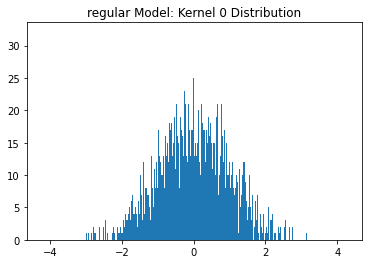

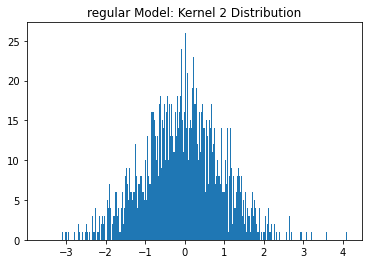

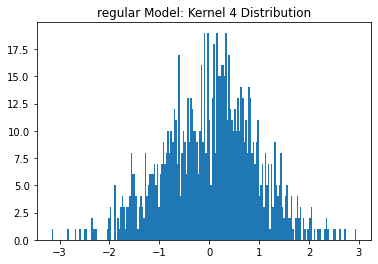

In [ ]:
visualizeAllDistributions(regular_model)

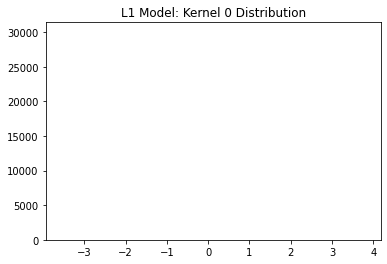

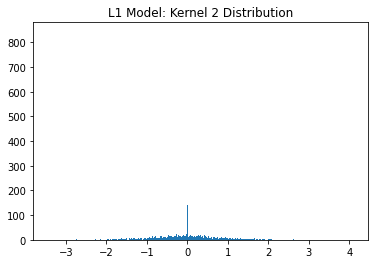

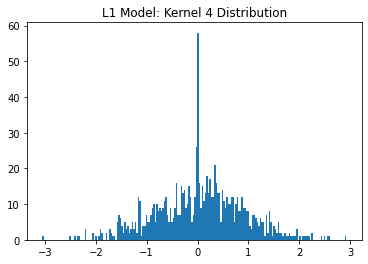

In [ ]:
visualizeAllDistributions(l1_model)

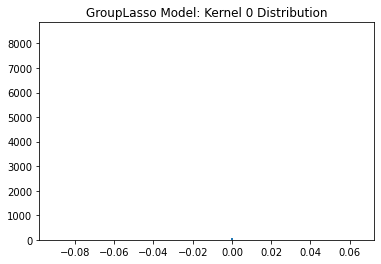

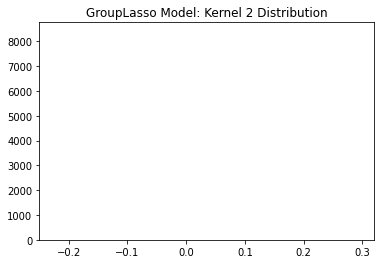

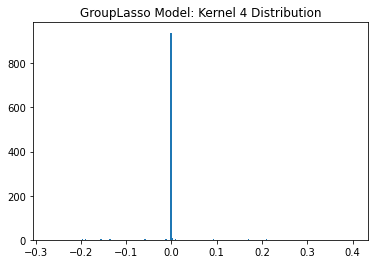

In [ ]:
visualizeAllDistributions(group_lasso_model)

##Visualizing Group Distributions

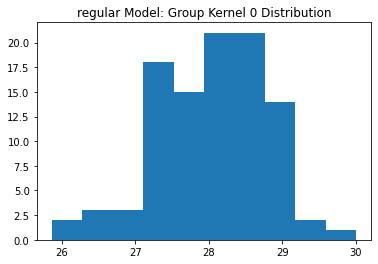

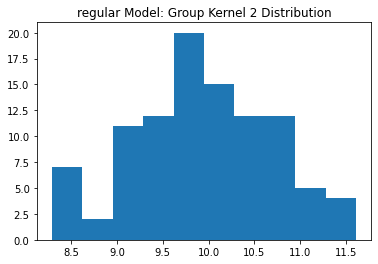

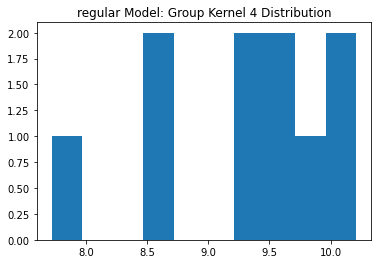

In [ ]:
visualizeAllGroupDistributions(regular_model)

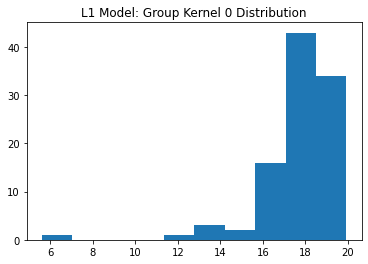

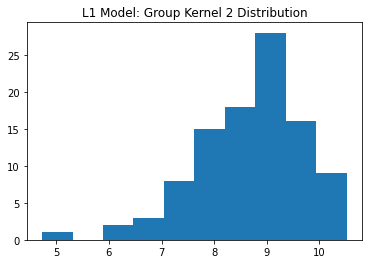

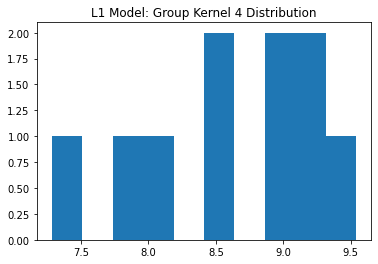

In [ ]:
visualizeAllGroupDistributions(l1_model)

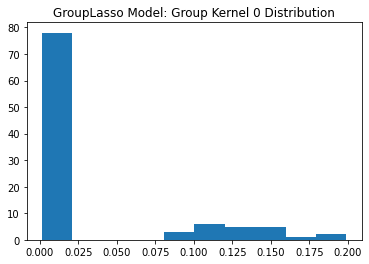

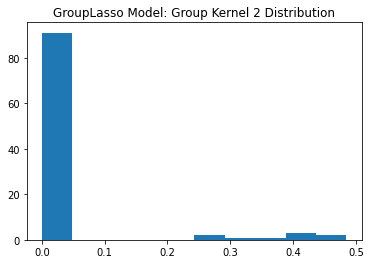

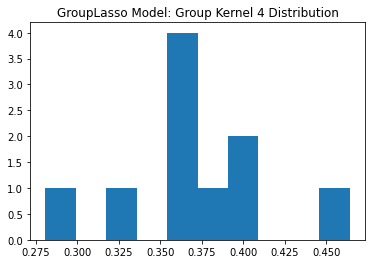

In [ ]:
visualizeAllGroupDistributions(group_lasso_model)

##Counting Zero Parameters and Groups

In [ ]:
def countAllZeroParameters(model, threshold=0.01):
  counter = 0
  variables = model.variables
  print("# parameters close to 0 in " + model.name + " Model: ")
  for variable in variables:
    if ("kernel" in variable.name):
      variable = variable.numpy()
      totalZeros = np.logical_and(variable<threshold, variable>-threshold).sum()
      print("\tKernel " + str(counter) + ": " + str(totalZeros) + " parameters (" + str(round(totalZeros*100./variable.size, 2)) + "%)")
    counter+=1

def countAllZeroGroups(model, threshold=0.05):
  counter = 0
  variables = model.variables
  print("# groups close to 0 in " + model.name + " Model: ")
  for variable in variables:
    if ("kernel" in variable.name):
      group_norms = []
      for c in range(variable.shape[1]):
        group = variable[:,c]
        group_norm = np.sqrt(np.sum(np.square(group)))
        group_norms.append(group_norm)
      totalZeroGroups = (np.abs(group_norms)<threshold).sum()
      print("\tKernel " + str(counter) + ": " + str(totalZeroGroups) + " groups (" + str(round(totalZeroGroups*100./variable.shape[1], 2)) + "%)")
      counter += 1

In [ ]:
countAllZeroParameters(regular_model)
countAllZeroParameters(l1_model)
countAllZeroParameters(group_lasso_model)

# parameters close to 0 in regular Model: 
	Kernel 0: 614 parameters (0.78%)
	Kernel 2: 73 parameters (0.73%)
	Kernel 4: 9 parameters (0.9%)
# parameters close to 0 in L1 Model: 
	Kernel 0: 39371 parameters (50.22%)
	Kernel 2: 1294 parameters (12.94%)
	Kernel 4: 55 parameters (5.5%)
# parameters close to 0 in GroupLasso Model: 
	Kernel 0: 77695 parameters (99.1%)
	Kernel 2: 9904 parameters (99.04%)
	Kernel 4: 948 parameters (94.8%)


In [ ]:
countAllZeroGroups(regular_model)
countAllZeroGroups(l1_model)
countAllZeroGroups(group_lasso_model)

# groups close to 0 in regular Model: 
	Kernel 0: 0 groups (0.0%)
	Kernel 1: 0 groups (0.0%)
	Kernel 2: 0 groups (0.0%)
# groups close to 0 in L1 Model: 
	Kernel 0: 0 groups (0.0%)
	Kernel 1: 0 groups (0.0%)
	Kernel 2: 0 groups (0.0%)
# groups close to 0 in GroupLasso Model: 
	Kernel 0: 78 groups (78.0%)
	Kernel 1: 91 groups (91.0%)
	Kernel 2: 0 groups (0.0%)


#Evaluating performance after removing groups

In [ ]:
def removeZeroGroups(model, threshold=0.01):
    counter = 0
    variables = model.variables
    newVariables = []
    for variable in variables:
      if ("kernel" in variable.name):
        variable_value = variable.numpy()
        group_norms = []
        n_groups = 0
        for c in range(variable.shape[1]):
          group = variable[:,c]
          group_norm = np.sqrt(np.sum(np.square(group)))
          if (group_norm < threshold):
            n_groups += 1
            variable_value[:,c] = 0
          group_norms.append(group_norm)
        print("Removed " + str(n_groups) + " groups from variable #" + str(counter) + " (" + str(round(n_groups*100./variable.shape[1], 2)) + "% of total)")
        variable.assign(tf.convert_to_tensor(variable_value))
      counter += 1

In [ ]:
removeZeroGroups(group_lasso_model)
loss, accuracy = group_lasso_model.evaluate(x=X_test, y=Y_test)

Removed 78 groups from variable #0 (78.0% of total)
Removed 91 groups from variable #2 (91.0% of total)
Removed 0 groups from variable #4 (0.0% of total)
313/313 [==============================] - 1s 3ms/step - loss: 0.3885 - accuracy: 0.9628


#Visualizing Results with Tensorboard

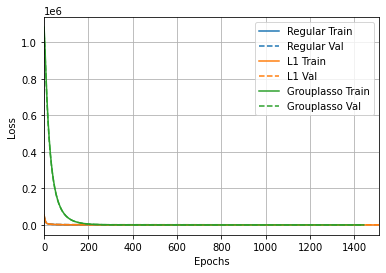

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(histories)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}

In [ ]:
tensorboard dev list

In [ ]:
!tensorboard dev upload --logdir  {logdir} \
  --name "Regularizer experiment with MNIST" \
  --description "Implementing and testing group lasso regularizer" \
  --one_shot